In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../Data/hitters.csv')
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [3]:
df['Division'].unique()

array(['W', 'E'], dtype=object)

In [4]:
df['League'].unique()

array(['N', 'A'], dtype=object)

In [5]:
df['NewLeague'].unique()

array(['N', 'A'], dtype=object)

In [6]:
from sklearn.preprocessing import LabelEncoder

# encode string columns to int cols
lbl_make = LabelEncoder()
df['Division_Int'] = lbl_make.fit_transform(df['Division'])
df['League_Int'] = lbl_make.fit_transform(df['League'])
df['NewLeague_Int'] = lbl_make.fit_transform(df['NewLeague'])

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE # recursive feature elimination
from sklearn.metrics import r2_score

X_cols = [x for x in df.columns if x not in ['Salary', 'Division', 
                                               'League', 'NewLeague']]
X = df[X_cols]
y = df['Salary']

estimator = LinearRegression()
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X,y)

In [8]:
X_cols_final = X.columns[selector.support_ ]
X_cols_final

Index(['HmRun', 'Walks', 'Years', 'Division_Int', 'League_Int'], dtype='object')

In [9]:
selector.ranking_

array([ 5,  3,  1,  4,  6,  1,  1, 14, 15, 10,  7,  9,  8, 13, 12, 11,  1,
        1,  2])

In [10]:
reg = LinearRegression().fit(X,y)
r_2 = r2_score(y, reg.predict(X))

adj_r_2 = 1 - (1 - r_2) * ( (df.shape[0] - 1) / (df.shape[0] - len(X_cols) - 1) )

r_2, adj_r_2

(0.5461158619125321, 0.5106269786875861)

In [11]:
reg = LinearRegression().fit(X[X_cols_final],y)
r_2 = r2_score(y, reg.predict(X[X_cols_final]))

adj_r_2 = 1 - (1 - r_2) * ( (df.shape[0] - 1) / (df.shape[0] - len(X_cols_final) - 1) )

r_2, adj_r_2

(0.3634506139833972, 0.3510663846834633)

More features = better peformance, even after using adjusted R^2.

##### Using train set and test set

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
estimator = LinearRegression()
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X_train,y_train)

X_cols_final = X.columns[selector.support_ ]

In [14]:
reg = LinearRegression().fit(X_train,y_train)
r_2 = r2_score(y_test, reg.predict(X_test))

adj_r_2 = 1 - (1 - r_2) * ( (df.shape[0] - 1) / (df.shape[0] - len(X_cols) - 1) )

r_2, adj_r_2

(0.36753015454782945, 0.3180777798005404)

In [15]:
reg = LinearRegression().fit(X[X_cols_final],y)
r_2 = r2_score(y, reg.predict(X[X_cols_final]))

adj_r_2 = 1 - (1 - r_2) * ( (df.shape[0] - 1) / (df.shape[0] - len(X_cols_final) - 1) )

r_2, adj_r_2

(0.27901196063917655, 0.2649849559823513)

Both perform worse when using train and test set, but adjusted r^2 are closer for the two.

##### Choosing best among models with cross validation

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

# select model with lowest average MSE with number of predictors
estimator = LinearRegression()

arr_mse = []
arr_r_2 = []

for num_pred in range(1, len(X_cols)-5):
    selector = RFE(estimator, num_pred, step=1)
    cv_results = cross_validate(selector, X, y, cv=3, 
                                scoring=('r2', 'neg_mean_squared_error'))
    arr_mse.append(cv_results['test_neg_mean_squared_error'].mean())
    arr_r_2.append(cv_results['test_r2'].mean())
    
    
arr_mse

[-198137.9812256503,
 -192200.44315722465,
 -176041.62691411705,
 -166943.12998673655,
 -139349.76375341168,
 -130091.29239848908,
 -123319.83990238832,
 -120617.07695608726,
 -122650.4527851238,
 -126410.0371371372,
 -120464.73732221808,
 -119453.90459125304,
 -124949.85100411536]

In [17]:
idx_min = np.argmin([abs(x) for x in arr_mse])
arr_mse[idx_min], idx_min

(-119453.90459125304, 11)

In [18]:
idx_max = np.argmax([abs(x) for x in arr_r_2])
arr_r_2[idx_max], idx_max

(0.3886733871126262, 7)

## Ridge and lasso regression with CV

#### Ridge

In [19]:
from sklearn.linear_model import RidgeCV

clf = RidgeCV(alphas=np.arange(0.1, 1.1, 0.1)).fit(X_train, y_train)
y_pred = clf.predict(X_test)

r_2 = r2_score(y_test, y_pred)
adj_r_2 = 1 - (1 - r_2) * ( (df.shape[0] - 1) / (df.shape[0] - len(X_cols) - 1) )

r_2, adj_r_2

(0.36781806139801965, 0.31838819788593065)

In [20]:
clf.alpha_, clf.coef_

(1.0,
 array([-2.14137472e+00,  9.95826060e+00,  6.60942697e+00, -4.70259529e+00,
        -4.70129988e+00,  8.10702771e+00, -6.97585223e+00, -3.56339933e-02,
        -3.93359708e-01,  1.34908117e+00,  1.78675400e+00,  5.66517678e-01,
        -1.06936248e+00,  2.50492744e-01,  3.04146540e-01,  2.39316654e-01,
        -1.19079275e+02,  2.16926839e+01,  3.47780032e+01]))

#### Lasso

In [21]:
from sklearn.linear_model import LassoCV

clf = LassoCV(cv=10, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

r_2 = r2_score(y_test, y_pred)
adj_r_2 = 1 - (1 - r_2) * ( (df.shape[0] - 1) / (df.shape[0] - len(X_cols) - 1) )

r_2, adj_r_2

(0.4666945880200877, 0.42499581095169947)

In [22]:
clf.alpha_, clf.coef_

(578.6517026311567,
 array([-0.        ,  1.42002629, -0.        ,  0.        , -0.        ,
         1.57548521, -0.        , -0.24162418,  0.33762211,  0.        ,
         1.04370954,  0.73711797, -0.04646893,  0.24150624,  0.21449015,
        -0.        , -0.        ,  0.        ,  0.        ]))

## PCA

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
# https://etav.github.io/python/scikit_pca.html
from sklearn.decomposition import PCA

covar_matrix = PCA(n_components = len(X_cols))

In [24]:
covar_matrix.fit(X)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([97.4, 98.7, 99.2, 99.5, 99.7, 99.8, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9])

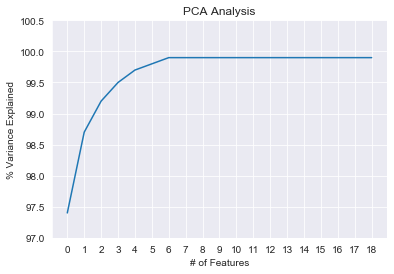

In [25]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(97, 100.5)
plt.xticks(np.arange(0, len(X_cols)+2, 1))
plt.style.context('seaborn-whitegrid')


plt.plot(var)

## Partial Least Squares (PLS)

PCA but considers response variable as well when determining hyperplanes of maximum variance.

In [26]:
from sklearn.cross_decomposition import PLSRegression

arr_r_2 = []

for n_comp in range(1, len(X_cols)):
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X_train, y_train)
    r_2 = r2_score(y_test, pls.predict(X_test))
    arr_r_2.append(r_2)

arr_r_2

[0.3978880956368517,
 0.3952082959465526,
 0.38758429675129036,
 0.4109127391783437,
 0.34478752053868633,
 0.3088442233809542,
 0.32347498349949144,
 0.3859483699376981,
 0.3775137374899361,
 0.37837941891836213,
 0.3871981475175479,
 0.37008285497076787,
 0.3593132014722876,
 0.3606418198875122,
 0.36895533931193447,
 0.379501249672235,
 0.3768154414691439,
 0.374045139528156]

In [27]:
idx_max = np.argmax(arr_r_2)
print(f'{idx_max}: {round(arr_r_2[idx_max] * 100, 2)}%')

3: 41.09%


## Exercises

### 8.

In [28]:
# R rnorm - scipy.stats.norm.cdf()
# R qnorm - scipy.stats.norm.ppf()

from scipy.stats import norm

x = np.random.randint(-250, 250, size=100)
np.random.shuffle(x)

X = np.array(norm.cdf(x))
epsilon = np.random.randint(-10, 10, size=100)

X = X.reshape(len(X), 1)

In [29]:
from sklearn.preprocessing import PolynomialFeatures

beta0 = 3
beta1 = 2
beta2 = -3
beta3 = 0.3

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

X_poly[:, 0] *= beta0
X_poly[:, 1] *= beta1
X_poly[:, 2] *= beta2
X_poly[:, 3] *= beta3

y = np.sum(X_poly, axis=1) + epsilon

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_poly, y)

In [31]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

# select model with lowest average MSE with number of predictors
estimator = LinearRegression()

arr_mse = []
arr_r_2 = []

for num_pred in range(1, 4):
    selector = RFE(estimator, num_pred, step=1) # recursive feature elmination
    reg = selector.fit(X_train,y_train)
    r_2 = r2_score(y_test, reg.predict(X_test))
    mse = mean_squared_error(y_test, reg.predict(X_test))
    arr_r_2.append(r_2)
    arr_mse.append(mse)
    
    
arr_r_2, arr_mse

([-0.10746544384804069, -83811473121.30869, -77249341704.41707],
 [35.5259327856241, 2688554101030.5605, 2478050160756.9062])

Simplest model with one variable works best.

### 9.

In [32]:
df = pd.read_csv('../Data/colleges.csv')
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# encode string columns to int cols
lbl_make = LabelEncoder()
df['Private_Int'] = lbl_make.fit_transform(df['Private'])

X_cols = [x for x in df.columns if x not in ['Private', 'Apps']]
X = df[X_cols]
y = df['Apps']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_pred)}')

MSE = 1407384.1188819488


In [35]:
from sklearn.linear_model import RidgeCV
ridge_reg = RidgeCV(alphas=np.arange(0.1, 100, 0.1)).fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

mse, ridge_reg.alpha_

(1405755.4336764072, 24.700000000000003)

In [36]:
from sklearn.linear_model import LassoCV
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

mse, lasso_reg.alpha_, lasso_reg.coef_

(1592127.1378012681,
 15600.976313113335,
 array([ 1.60951136, -0.88052897,  0.        ,  0.        ,  0.08687419,
        -0.02391452, -0.08233886,  0.09819007,  0.        ,  0.        ,
         0.        , -0.        ,  0.        ,  0.        ,  0.14279408,
         0.        , -0.        ]))

Text(0.5, 1.0, 'R^2 of different models')

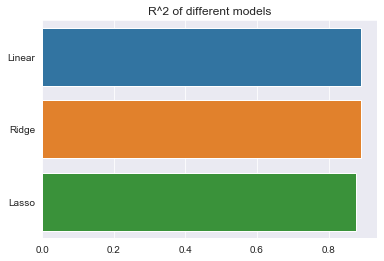

In [37]:
lin_r2 = r2_score(y_test, lin_reg.predict(X_test))
ridge_r2 = r2_score(y_test, ridge_reg.predict(X_test))
lasso_r2 = r2_score(y_test, lasso_reg.predict(X_test))

sns.barplot([lin_r2, ridge_r2, lasso_r2],
            ['Linear', 'Ridge', 'Lasso'], 
            orient='h')

plt.title('R^2 of different models')